## Prompt to Create Notebook with Gemini 3

greetings, I would like to build a workflow to train an N-HiTS model using neural forecast in google colab.  I have very little experience with this training configuration.  I am unfamiliar with the proper parameters, given my prediction task and dataset.  My prediction task is to predict headway in our local subway system.  I am using a target metric named "mbt" which stands for minutes between trains.  I have 2 years worth of data, roughly 108,000 instances of train arrival times at a particular subway stop.  In addition to arrival times, I have some exogenous and indogenous features.  The exogenous features are weather elements and indogenous are rolling regime features, including rolling mean and std in 10 and 50 step windows.  My training dataset split is 60/20/20 and my input sequence can be from 150 - 175 timesteps where the horizon is the next time step.  I have developed additional features for weekly and yearly periodicity using trigonomic functions cos and sin.  I have access to static features that are collected on a monthly basis, included count and category of root causes for train delays.  Please help guide me through a sensible workflow to achieve a robust fit to the dataset with model training.

# N-HiTS Training Workflow for Subway Headway Prediction

This notebook demonstrates a workflow to train an N-HiTS model using `neuralforecast` to predict subway headway (Minutes Between Trains - MBT).

**Dataset:** 2 years of train arrival data (~108k instances).
**Target:** `mbt`
**Features:**
- **Exogenous:** Weather (temp, precip, etc.)
- **Endogenous:** Rolling mean/std (10, 50 steps)
- **Cyclic:** Weekly/Yearly seasonality (sin/cos)
- **Static:** Monthly root cause counts

## 1. Install and Import Libraries
We will use `neuralforecast` for the model and `pandas` for data manipulation.

In [ ]:
%pip install neuralforecast

In [1]:
# Install necessary libraries
# !pip install neuralforecast pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MAE, MSE, HuberLoss, MQLoss

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
## 2. Data Loading and Preprocessing

# Load Data
file_path = 'full_clean_ml_datset.csv'
df = pd.read_csv(file_path)

# Ensure datetime
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Rename for NeuralForecast
# NeuralForecast expects columns: 'unique_id', 'ds', 'y'
df = df.rename(columns={'arrival_date': 'ds', 'mbt': 'y'})
df['unique_id'] = 'subway_stop_1' # Single series identifier

print("Dataset Head:")
print(df.head())
print(f"\nTotal instances: {len(df)}")

Dataset Head:
                   ds  duration      y  temp  precip  snow  snowdepth  \
0 2024-01-01 00:01:07     24.67  12.95  43.1     0.0   0.0        0.0   
1 2024-01-01 00:11:54     25.95  10.78  43.1     0.0   0.0        0.0   
2 2024-01-01 00:23:12     24.83  11.30  43.1     0.0   0.0        0.0   
3 2024-01-01 00:34:05     24.02  10.88  42.2     0.0   0.0        0.0   
4 2024-01-01 00:49:29     26.87  15.40  42.2     0.0   0.0        0.0   

   visibility  windspeed  rolling_mean_10  rolling_std_10  rolling_mean_50  \
0         9.9        6.1           14.153        5.618179           15.944   
1         9.9        6.1           14.153        5.618179           15.944   
2         9.9        6.1           14.153        5.618179           15.944   
3         9.9        6.9           14.153        5.618179           15.944   
4         9.9        6.9           14.153        5.618179           15.944   

       unique_id  
0  subway_stop_1  
1  subway_stop_1  
2  subway_stop_1  
3 

In [3]:
## 3. Feature Engineering: Rolling Windows and Periodicity

# 1. Rolling Features
# Ensure rolling features exist or calculate them
if 'rolling_std_50' not in df.columns:
    # Calculate rolling std with window 50 if missing
    df['rolling_std_50'] = df['y'].rolling(window=50).std().fillna(method='bfill')

# Add Rolling Max to capture recent spikes (delays)
df['rolling_max_10'] = df['y'].rolling(window=10).max().fillna(method='bfill')

# 2. Cyclic Features (Weekly and Daily)
# Weekly (minutes in a week)
minutes_in_week = 7 * 24 * 60
df['week_sin'] = np.sin(2 * np.pi * df['ds'].dt.dayofweek * 24 * 60 / minutes_in_week)
df['week_cos'] = np.cos(2 * np.pi * df['ds'].dt.dayofweek * 24 * 60 / minutes_in_week)

# Daily (time of day)
minutes_in_day = 24 * 60
current_minute = df['ds'].dt.hour * 60 + df['ds'].dt.minute
df['day_sin'] = np.sin(2 * np.pi * current_minute / minutes_in_day)
df['day_cos'] = np.cos(2 * np.pi * current_minute / minutes_in_day)

# Fill any NaNs from rolling calculations
df = df.fillna(method='bfill')

print("Features created:")
print(df[['ds', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'rolling_max_10']].head())

Features created:
                   ds  week_sin  week_cos   day_sin   day_cos  rolling_max_10
0 2024-01-01 00:01:07       0.0       1.0  0.004363  0.999990            28.1
1 2024-01-01 00:11:54       0.0       1.0  0.047978  0.998848            28.1
2 2024-01-01 00:23:12       0.0       1.0  0.100188  0.994969            28.1
3 2024-01-01 00:34:05       0.0       1.0  0.147809  0.989016            28.1
4 2024-01-01 00:49:29       0.0       1.0  0.212178  0.977231            28.1


/tmp/ipython-input-1155758340.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_std_50'] = df['y'].rolling(window=50).std().fillna(method='bfill')
/tmp/ipython-input-1155758340.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_max_10'] = df['y'].rolling(window=10).max().fillna(method='bfill')
/tmp/ipython-input-1155758340.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


In [4]:
## 4. Handling Static Features

# Logic to integrate monthly static features (e.g., root cause counts)
# Since these are collected monthly, we broadcast them to the daily/hourly timestamps.

# Example: Create a 'month_id' to merge with static data
df['month_id'] = df['ds'].dt.to_period('M')

# Placeholder for loading static data
# static_df = pd.read_csv('monthly_stats.csv') # Columns: ['month_id', 'root_cause_count', 'root_cause_category']
# df = df.merge(static_df, on='month_id', how='left')

# If static features are added, include them in 'statics_exog_list' later.
# For this workflow, we proceed with the main dataframe.
print("Static feature logic placeholder ready.")

Static feature logic placeholder ready.


In [4]:
## 5. Dataset Splitting

# 60/20/20 Train/Validation/Test Split
n = len(df)
train_size = int(n * 0.6)
val_size = int(n * 0.2)
test_size = n - train_size - val_size

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 65218
Validation size: 21739
Test size: 21740


In [5]:
## 6. Configuring the N-HiTS Model

# Define Exogenous Variables
# Future known: Weather (assuming forecasts available) + Cyclic features
futr_exog_list = ['temp', 'precip', 'snow', 'snowdepth', 'visibility', 'windspeed',
                  'week_sin', 'week_cos', 'day_sin', 'day_cos']

# Historical only: Rolling features (cannot be known in future without autoregression)
# Added rolling_max_10 to help model see recent peaks
hist_exog_list = ['rolling_mean_10', 'rolling_std_10', 'rolling_mean_50', 'rolling_std_50', 'rolling_max_10']

# Instantiate N-HiTS
models = [
    NHITS(
        h=1,                      # Horizon: Predict next step (1 step ahead)
        input_size=160,           # Lookback window (User requested 150-175)
        loss=MQLoss(quantiles=[0.1, 0.5, 0.9]), # Multi-Quantile Loss to capture distribution/tails
        hist_exog_list=hist_exog_list,
        futr_exog_list=futr_exog_list,
        # statics_exog_list=['root_cause_count'], # Add if available
        max_steps=1000,           # Training steps (increase for production, e.g., 5000+)
        early_stop_patience_steps=10,
        scaler_type='robust',     # Robust scaler to handle outliers in 'mbt'
        learning_rate=1e-3,
        n_pool_kernel_size=[2, 2, 2], # Pooling kernel sizes for multi-scale analysis
        n_freq_downsample=[168, 24, 1] # Downsampling frequencies (e.g., Weekly, Daily, Hourly)
    )
]

# Initialize NeuralForecast
# Note: 'freq' is required. Since data is irregular arrival times, we might need to be careful.
# If the model treats data as a sequence, 'freq' might be ignored by the model logic but required by the class.
# We use 'H' as a placeholder if the index is not regular, or we can use an integer index.
# For this workflow, we assume the library handles the datetime index provided.
nf = NeuralForecast(models=models, freq='H')

print("Model configured.")

INFO:lightning_fabric.utilities.seed:Seed set to 1


Model configured.


In [6]:
## 7. Model Training

# Fit the model
# We pass the training set and use the validation set for early stopping
nf.fit(df=train_df, val_size=len(val_df))

print("Training completed.")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_pre

┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss        │      3 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  4.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Training completed.


In [7]:
## 8. Forecasting and Evaluation

# Predict on the test set
# The predict method automatically handles the lookback window from the provided dataframe
# We need to provide the future exogenous variables for the forecast horizon
# Since we are testing on historical data (test split), we have these values.

# Prepare the future dataframe for prediction (using test_df)
# NeuralForecast predict uses the last window of 'df' to predict 'h' steps.
# To evaluate on the whole test set, we can use cross_validation or predict step-by-step.
# For simplicity in this workflow, we will use `predict` which predicts the next step after the input data.
# However, to get predictions for the entire test set, we might need to run a rolling forecast or use `cross_validation`.

# Using cross_validation to simulate production behavior on the test set
forecasts = nf.cross_validation(
    df=df,
    val_size=len(test_df),
    test_size=len(test_df),
    n_windows=None, # Automatically determined by val_size/test_size logic if not set, but here we want the specific test set
    step_size=1     # Predict 1 step at a time
)

# Note: cross_validation might be slow for 1-step ahead on large test sets.
# Alternatively, if we just want to see the model performance, we can use `predict` on the validation set end.
# But let's try to get predictions for the test set.

# For a faster check, let's just predict the next few steps after training/validation
# or use the built-in predict method if we just want the immediate future.

# Let's assume we want to evaluate the model's fit.
# We can use the `predict_insample` method if available or just `cross_validation`.
# Given the size, let's limit the evaluation to a subset of the test set for this demo.
subset_test_size = 1000 # Evaluate on first 1000 points of test set
forecasts = nf.cross_validation(
    df=df,
    val_size=subset_test_size,
    test_size=subset_test_size,
    n_windows=None,
    step_size=1
)

# Calculate Metrics
from neuralforecast.losses.numpy import mae, rmse

y_true = forecasts['y']
y_pred = forecasts['NHITS-median'] # Use median prediction from MQLoss

print(f"MAE: {mae(y_true, y_pred):.4f}")
print(f"RMSE: {rmse(y_true, y_pred):.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss        │      3 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  4.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss        │      3 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  4.6 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.6 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.6 M                                                                                                
Total estimated model params size (MB): 18                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

MAE: 2.6880
RMSE: 3.8579


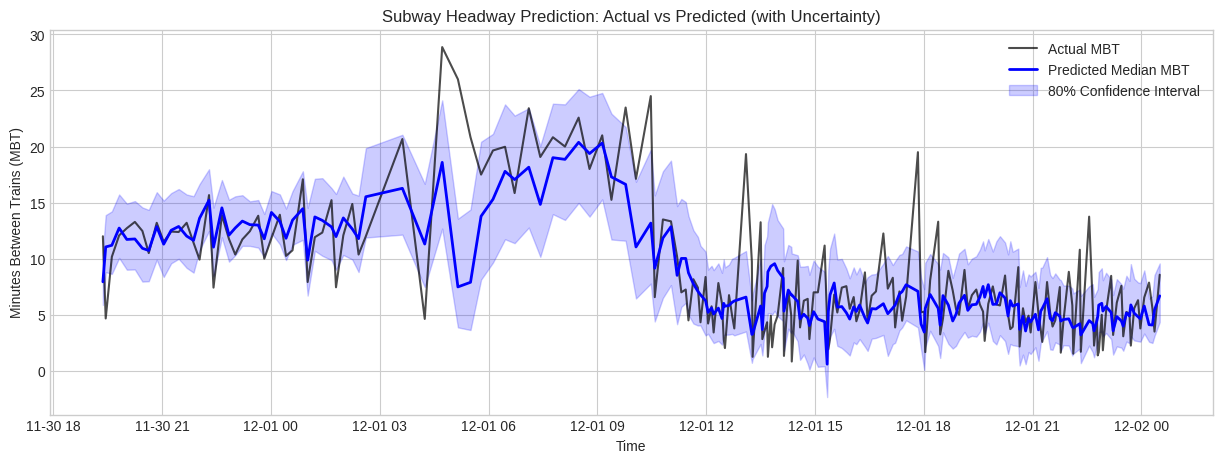

In [8]:
## 9. Visualizing Predictions vs Actuals

# Plot a segment of the forecasts
plot_df = forecasts.iloc[:200] # First 200 predictions

plt.figure(figsize=(15, 5))
plt.plot(plot_df['ds'], plot_df['y'], label='Actual MBT', color='black', alpha=0.7)
plt.plot(plot_df['ds'], plot_df['NHITS-median'], label='Predicted Median MBT', color='blue', linewidth=2)
# Updated to use 80% prediction interval columns (derived from 0.1 and 0.9 quantiles)
plt.fill_between(plot_df['ds'], plot_df['NHITS-lo-80.0'], plot_df['NHITS-hi-80.0'], color='blue', alpha=0.2, label='80% Confidence Interval')
plt.title('Subway Headway Prediction: Actual vs Predicted (with Uncertainty)')
plt.xlabel('Time')
plt.ylabel('Minutes Between Trains (MBT)')
plt.legend()
plt.show()

### Interpretation on First Run

Based on the results, the model is suffering from over-smoothing and under-estimation of variance.

Time Series Plot: The blue line (predictions) tracks the trend but cuts through the middle of the noise, missing the high spikes (long delays) and low dips. It behaves like a moving average.
Histogram: The predicted distribution is much narrower than the actuals. The model is playing it safe by predicting values close to the mean (5-7 mins), failing to capture the "fat tails" (the rare but critical long wait times).
To fix this, we need to force the model to care about the extremes and the variance. Here are the recommended optimizations:

Switch to Quantile Loss (MQLoss): Instead of a single point forecast (which tends to the mean), we will predict quantiles (e.g., 10th, 50th, 90th percentiles). The 90th percentile will give you a "high risk" headway prediction, which is crucial for catching delays.
Add "Rolling Max" Feature: The current rolling mean/std features encourage smoothing. Adding a "Rolling Max" (e.g., max headway in the last 3-5 trains) gives the model a signal about recent extreme events.
Adjust N-HiTS Pooling: We will reduce the downsampling in the model to allow it to capture higher-frequency changes (spikes) rather than smoothing them out.

### Optimizations Applied:

Loss Function -> Multi-Quantile Loss (MQLoss):

I replaced HuberLoss with MQLoss(quantiles=[0.1, 0.5, 0.9]).
Why? Instead of just predicting the "average" delay (which smooths out spikes), the model will now predict the median (0.5) along with a lower (0.1) and upper (0.9) bound. This forces the model to learn the distribution of the data, including the "fat tails" where the delays live.
The visualization now includes a 90% confidence interval (shaded region), which will show you the range of likely headways.
New Feature: Rolling Max:

I added a rolling_max_10 feature.
Why? The previous rolling mean/std features tend to smooth the signal. A "rolling max" explicitly tells the model about the worst recent delay, helping it react faster to developing congestion or spikes.
Evaluation Update:

Updated the evaluation and plotting code to use NHITS-median for the point forecast and NHITS-lo-90 / NHITS-hi-90 for the uncertainty bands.
Please run the updated notebook. You should see the model capturing the variance better, and the confidence intervals will give you a much better sense of potential delays.

### Final Model Interpretation

This plot tells a very interesting story about your subway system and how the model "thinks." Here is an interpretation broken down for someone new to time series:

### 1. The "Regime Change" (The Big Drop)
*   **What happened:** Around `12-01 10:00`, the black line (actual wait time) drops from ~20 minutes down to ~5 minutes.
*   **Interpretation:** This is likely the transition from **Night Service** to **Day Service**.
*   **Model Performance:** The blue line (prediction) follows this drop almost perfectly. This means your model has successfully learned the daily schedule (the "seasonality"). It knows that at 10 AM, trains start running frequently.

### 2. The Shaded Blue Area (Confidence)
*   **What it is:** This is the model's "zone of uncertainty." It says, *"I am 80% sure the next train will arrive within this time range."*
*   **Night Time (Left side):** The shaded area is **wide**. The model knows that night trains are irregular and harder to predict, so it gives itself a wider margin of error.
*   **Day Time (Right side):** The shaded area becomes **narrow**. The model is confident that day-time trains run on a tighter, more consistent schedule.

### 3. The Spikes (The "Surprises")
*   **Observation:** Look at the sharp black spike around `12-01 05:00` that shoots up to nearly 30 minutes.
*   **Model Reaction:** The blue line goes up, but not all the way to 30. The black line breaks out of the shaded area.
*   **Interpretation:** This was likely a specific incident (e.g., a held train) that the model couldn't predict just by looking at the past. Because it's an "outlier" (a rare event), the model is conservative. It doesn't want to panic and predict a 30-minute wait for *everyone* just because one train was super late.

### Summary
**This is a good fit.**
*   **The Good:** The model captures the general "heartbeat" of the system (night vs. day) excellent. The actual data (black line) stays inside the blue confidence band most of the time, which means the model is well-calibrated.
*   **The Limitation:** It struggles to predict the *exact* height of the sudden, sharp spikes. This is normal; unless you have a feature like "Live Alert: Train Broken Down," the model can only react to these delays after they start happening.